In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path

## Setting seed for replication

## Constants

In [2]:
RESIZE_IMAGE_SIZE = [150, 150]
BATCH_SIZE = 32
EPOCHS = 20

## Loading the dataset

In [3]:
DATA_DIR = Path("./data/chest_xray/")

TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'

In [4]:
normal_train_dataset = TRAIN_DIR / 'NORMAL'
pneumonia_train_dataset = TRAIN_DIR / 'PNEUMONIA'

normal_test_dataset = TEST_DIR / 'NORMAL'
pneumonia_test_dataset = TEST_DIR / 'PNEUMONIA'

In [5]:
import cv2
from keras.utils import to_categorical

In [6]:
def parse_folder(dir, data, label):
    for img in dir.glob('*.jpeg'):
        try:
#             img_arr = cv2.imread(str(img))
#             resized_img = cv2.resize(img_arr, RESIZE_IMAGE_SIZE)
            data.append((img, label))
        except Exception as e:
            print('Error ', e)

In [7]:
def get_dataframe():
    data = []
    parse_folder(normal_train_dataset, data, False)
    parse_folder(pneumonia_train_dataset, data, True)
    train_dataset = pd.DataFrame(data, columns=['image', 'label'],index=None)
    #shuffle the dataset
    train_dataset = train_dataset.sample(frac=1.).reset_index(drop=True)

    return train_dataset

In [8]:
train_dataset = get_dataframe()
print(train_dataset.head(5))
print('Shape=',train_dataset.shape)

                                               image  label
0  data\chest_xray\train\PNEUMONIA\BACTERIA-55621...   True
1  data\chest_xray\train\PNEUMONIA\BACTERIA-99474...   True
2  data\chest_xray\train\PNEUMONIA\BACTERIA-42938...   True
3  data\chest_xray\train\PNEUMONIA\BACTERIA-52726...   True
4  data\chest_xray\train\PNEUMONIA\BACTERIA-40336...   True
Shape= (5232, 2)


In [9]:
def parseImage(src):
    img_arr = cv2.imread(str(src))
    resized_img = cv2.resize(img_arr, (150,150))
    return resized_img

In [10]:
def get_dataframe_test():
    data = []
    parse_folder(normal_test_dataset, data, False)
    parse_folder(pneumonia_test_dataset, data, True)
    train_dataset = pd.DataFrame(data, columns=['image', 'label'],index=None)
    #shuffle the dataset
    train_dataset = train_dataset.sample(frac=1.).reset_index(drop=True)

    return train_dataset

test_dataset = get_dataframe_test()
print(test_dataset.head(5))
print(test_dataset.shape)

                                               image  label
0  data\chest_xray\test\PNEUMONIA\BACTERIA-725721...   True
1  data\chest_xray\test\PNEUMONIA\BACTERIA-514119...   True
2  data\chest_xray\test\NORMAL\NORMAL-7804528-000...  False
3  data\chest_xray\test\NORMAL\NORMAL-2477476-000...  False
4  data\chest_xray\test\NORMAL\NORMAL-9104493-000...  False
(624, 2)


## Analysis 

### Distribution of training data

In [11]:
import seaborn as sns

In [12]:
def get_distribution(dataset, field):
    distribution = dataset[field].value_counts()
    print(distribution)

    plt.figure(figsize=(10, 10))
    sns.barplot(x=distribution.index, y=distribution.values)
    plt.title('No of cases')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.xticks(range(len(distribution)), ['Normal', 'Pneumonia'])
    return distribution

True     3883
False    1349
Name: label, dtype: int64


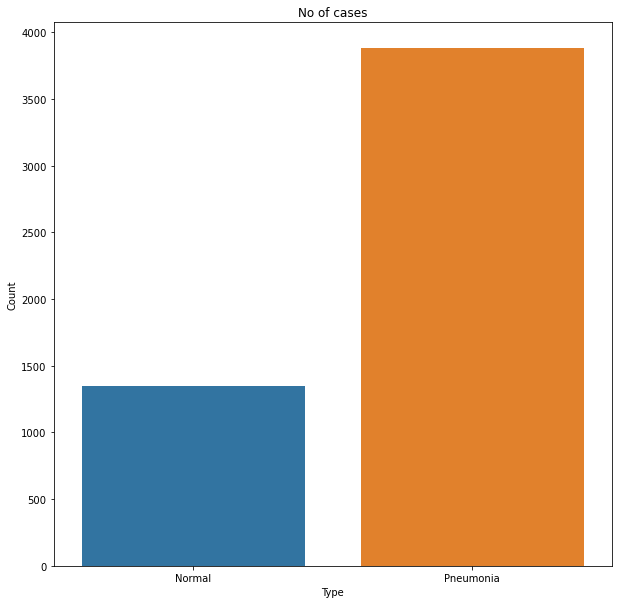

In [13]:
distribution = get_distribution(train_dataset, 'label')

### Correcting Imbalance

In [14]:
# we will try to correct this imbalance by assigning more weight to normal datasets than pneumonia ones
count_pnemonia = distribution[True]
count_normal = distribution[False]
count_total = len(train_dataset)
initial_bias = np.log([count_pnemonia/count_normal])
print('Initial bias = ', initial_bias)

Initial bias =  [1.05724447]


In [15]:
weight_for_normal = ((1 / count_normal)*count_total) / 2.0 
weight_for_pneumonia = ((1 / count_pnemonia)*count_total) / 2.0

class_weight = {False: weight_for_normal, True: weight_for_pneumonia}

print('Weight for class normal: {:.2f}'.format(weight_for_normal))
print('Weight for class pneumonia: {:.2f}'.format(weight_for_pneumonia))

Weight for class normal: 1.94
Weight for class pneumonia: 0.67


## Visualization

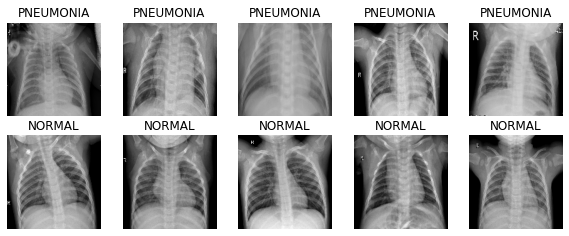

In [16]:
pneumonia_samples = (train_dataset[train_dataset['label']==True]['image'].iloc[:5]).tolist()
normal_samples = (train_dataset[train_dataset['label']==False]['image'].iloc[:5]).tolist()

samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
plt.figure(figsize=(10,10))
for n in range(10):
    img = parseImage(samples[n])
    ax = plt.subplot(5,5,n+1)
    plt.imshow(img)
    if n < 5:
        plt.title("PNEUMONIA")
    else:
        plt.title("NORMAL")
    plt.axis("off")

## Building the model

In [17]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [18]:
def conv_layer(filters):
    block = tf.keras.Sequential([
        Conv2D(filters, (3,3), activation='relu', padding='same' ),
        Conv2D(filters, (3,3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D()
    ])
    
    return block
    
def dense_layer(units, dropout_rate):
    block = tf.keras.Sequential([
        Dense(units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate)
    ])
    
    return block

In [19]:
vgg = VGG16(input_shape=RESIZE_IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False

In [40]:
def build_vgg_model(base_model):
    model = Sequential([
        base_model,
        Flatten(),
        dense_layer(4096,0.5),
        dense_layer(4096, 0.5),
        dense_layer(1000, 0.5),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(lr=0.0001, decay=1e-5)
    es = EarlyStopping(patience=5)
    chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
    model.compile(loss='binary_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')], 
                  optimizer=optimizer)
    return model, es, chkpt
model, es, chkpt = build_vgg_model(vgg)
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 4096)              33574912  
_________________________________________________________________
sequential_9 (Sequential)    (None, 4096)              16797696  
_________________________________________________________________
sequential_10 (Sequential)   (None, 1000)              4101000   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 1001      
Total params: 69,189,297
Trainable params: 54,456,225
Non-trainable params: 14,733,072
________________________________

In [22]:
image_gen = ImageDataGenerator(
        rescale = 1/255,
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range = 30, 
        zoom_range = 0.2, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        horizontal_flip = False,
        vertical_flip=False
    )

test_gen = ImageDataGenerator(rescale = 1/255)

(20, 150, 150, 3) (20,)


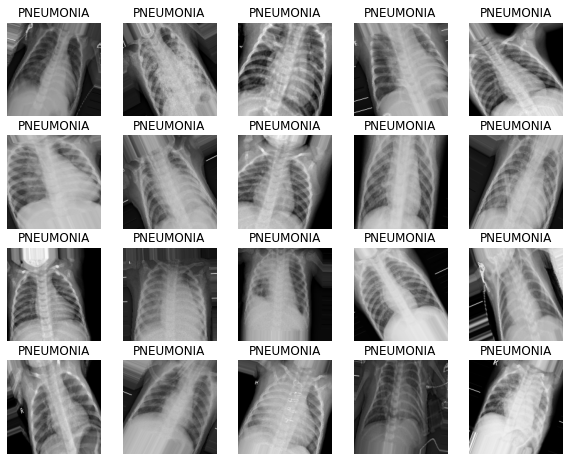

In [26]:
x, y = next(train_generator)
print(x.shape, y.shape)

plt.figure(figsize=(10,10))
for n in range(20):
    img = x[n]
    ax = plt.subplot(5,5,n+1)
    plt.imshow(img)
    if y[i]:
        plt.title("PNEUMONIA")
    else:
        plt.title("NORMAL")
    plt.axis("off")

In [49]:
x_train = [parseImage(img) for img in train_dataset.iloc[:, 0].values]
print(len(x_train))

5232


In [51]:
# normalize
x_train = np.array(x_train) #/ 255 
x_train = x_train.reshape(-1, 150, 150, 3)
print(len(x_train), x_train.shape)
y_train = [label for label in train_dataset.iloc[:, 1].values]
# y_train = np.array(y_train) / 255 
print(len(y_train))
image_gen.fit(x_train)

5232 (5232, 150, 150, 3)
5232


In [52]:
x_test = [parseImage(img) for img in test_dataset.iloc[:, 0].values]

In [53]:
x_test = np.array(x_test) #/ 255 
x_test = x_test.reshape(-1, 150, 150, 3)
print(len(x_test), x_test.shape)
y_test = [label for label in test_dataset.iloc[:, 1].values]
# y_test = np.array(y_test) / 255 
print(len(y_test))
test_gen.fit(x_test) 

624 (624, 150, 150, 3)
624


### Fine tuning

In [38]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
no_train_steps = train_dataset.shape[0]//BATCH_SIZE

## Training

In [54]:
history = model.fit(
                    image_gen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                    epochs=EPOCHS, 
                    steps_per_epoch=no_train_steps,
                    validation_data=test_gen.flow(x_test, y_test, batch_size=BATCH_SIZE),   
                    callbacks=[es, chkpt, lr_scheduler],
                    class_weight=class_weight)

Epoch 1/20
163/163 [==============================] - 340s 2s/step - loss: 0.2571 - accuracy: 0.8931 - precision: 0.9654 - recall: 0.8878 - val_loss: 1.0039 - val_accuracy: 0.6458 - val_precision: 1.0000 - val_recall: 0.4333 - lr: 0.0100
Epoch 2/20
163/163 [==============================] - 342s 2s/step - loss: 0.1907 - accuracy: 0.9294 - precision: 0.9805 - recall: 0.9234 - val_loss: 0.2142 - val_accuracy: 0.9215 - val_precision: 0.9596 - val_recall: 0.9128 - lr: 0.0089
Epoch 3/20
163/163 [==============================] - 362s 2s/step - loss: 0.1807 - accuracy: 0.9308 - precision: 0.9792 - recall: 0.9264 - val_loss: 0.1763 - val_accuracy: 0.9391 - val_precision: 0.9444 - val_recall: 0.9590 - lr: 0.0079
Epoch 4/20
163/163 [==============================] - 344s 2s/step - loss: 0.1691 - accuracy: 0.9323 - precision: 0.9782 - recall: 0.9295 - val_loss: 0.1987 - val_accuracy: 0.9279 - val_precision: 0.9832 - val_recall: 0.9000 - lr: 0.0071
Epoch 5/20
163/163 [============================

## Visualize performance

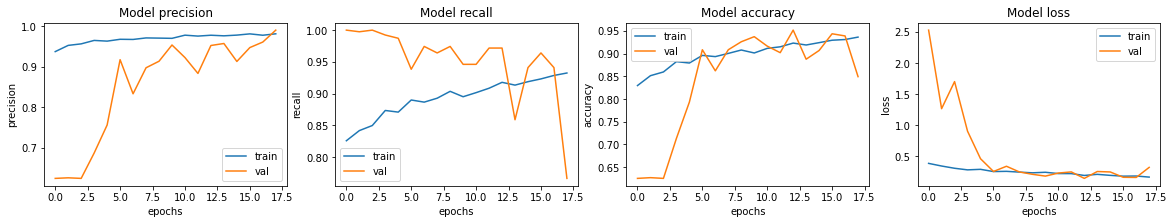

In [134]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
model.save('model_preprocess_vgg16.h5')